The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Gradiente Estocástico Descendente Minibatch
:label:`sec_minibatch_sgd`

Até agora, encontramos dois extremos na abordagem de aprendizagem baseada em gradiente: :numref:`sec_gd` usa o conjunto de dados completo para calcular gradientes e atualizar parâmetros, uma passagem de cada vez. Inversamente :numref:`sec_sgd` processa uma observação por vez para fazer progresso. Cada um deles tem suas próprias desvantagens. O Gradient Descent não é particularmente *eficiente em dados* sempre que os dados são muito semelhantes. Stochastic Gradient Descent não é particularmente *computacionalmente eficiente*, uma vez que CPUs e GPUs não podem explorar todo o poder da vetorização. Isso sugere que pode haver um meio-termo feliz e, de fato, é isso que temos usado até agora nos exemplos que discutimos.

## Vetorização e caches

No centro da decisão de usar minibatches está a eficiência computacional. Isso é mais facilmente compreendido quando se considera a paralelização para várias GPUs e vários servidores. Nesse caso, precisamos enviar pelo menos uma imagem para cada GPU. Com 8 GPUs por servidor e 16 servidores, já chegamos a um tamanho de minibatch de 128.

As coisas são um pouco mais sutis quando se trata de GPUs individuais ou até CPUs. Esses dispositivos têm vários tipos de memória, geralmente vários tipos de unidades de computação e diferentes restrições de largura de banda entre eles. Por exemplo, uma CPU tem um pequeno número de registradores e, em seguida, L1, L2 e, em alguns casos, até mesmo cache L3 (que é compartilhado entre os diferentes núcleos do processador). Esses caches têm tamanho e latência crescentes (e, ao mesmo tempo, largura de banda decrescente). Basta dizer que o processador é capaz de realizar muito mais operações do que a interface de memória principal é capaz de fornecer.

* Uma CPU de 2 GHz com 16 núcleos e vetorização AVX-512 pode processar até $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ bytes por segundo. A capacidade das GPUs facilmente excede esse número por um fator de 100. Por outro lado, um processador de servidor de médio porte pode não ter muito mais do que 100 GB/s de largura de banda, ou seja, menos de um décimo do que seria necessário para manter o processador alimentado. Para piorar a situação, nem todo acesso à memória é criado da mesma forma: primeiro, as interfaces de memória são normalmente de 64 bits ou mais largas (por exemplo, em GPUs de até 384 bits), portanto, a leitura de um único byte incorre no custo de um acesso muito mais amplo.
* Há uma sobrecarga significativa para o primeiro acesso, enquanto o acesso sequencial é relativamente barato (geralmente chamado de leitura intermitente). Há muito mais coisas para se manter em mente, como armazenamento em cache quando temos vários sockets, chips e outras estruturas. Uma discussão detalhada sobre isso está além do escopo desta seção. Veja, por exemplo, este [artigo da Wikipedia](https://en.wikipedia.org/wiki/Cache_hierarchy) para uma discussão mais aprofundada.

A maneira de aliviar essas restrições é usar uma hierarquia de caches de CPU que são realmente rápidos o suficiente para fornecer dados ao processador. Esta é *a* força motriz por trás dos lotes no aprendizado profundo. Para manter as coisas simples, considere a multiplicação matriz-matriz, digamos $\mathbf{A} = \mathbf{B}\mathbf{C}$. Temos várias opções para calcular $\mathbf{A}$. Por exemplo, podemos tentar o seguinte:

1. Poderíamos calcular $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, ou seja, poderíamos calculá-lo elemento a elemento por meio de produtos escalares.
1. Poderíamos calcular $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, ou seja, poderíamos calcular uma coluna de cada vez . Da mesma forma, poderíamos calcular $\mathbf{A}$ uma linha $\mathbf{A}_{i,:}$ de cada vez.
1. Poderíamos simplesmente calcular $\mathbf{A} = \mathbf{B} \mathbf{C}$.
1. Poderíamos quebrar $\mathbf{B}$ e $\mathbf{C}$ em matrizes de blocos menores e calcular $\mathbf{A}$ um bloco de cada vez.

Se seguirmos a primeira opção, precisaremos copiar um vetor linha e uma coluna para a CPU cada vez que quisermos calcular um elemento $\mathbf{A}_{ij}$. Pior ainda, devido ao fato de que os elementos da matriz estão alinhados sequencialmente, somos obrigados a acessar muitas localizações disjuntas para um dos dois vetores à medida que os lemos da memória. A segunda opção é muito mais favorável. Nele, podemos manter o vetor coluna $\mathbf{C}_{:,j}$ no cache da CPU enquanto continuamos percorrendo $B$. Isso reduz pela metade o requisito de largura de banda de memória com acesso correspondentemente mais rápido. Claro, a opção 3 é a mais desejável. Infelizmente, a maioria das matrizes pode não caber inteiramente no cache (é isso que estamos discutindo, afinal). No entanto, a opção 4 oferece uma alternativa prática útil: podemos mover blocos da matriz para o cache e multiplicá-los localmente. Bibliotecas otimizadas cuidam disso para nós. Vejamos como essas operações são eficientes na prática.

Além da eficiência computacional, a sobrecarga introduzida pelo Python e pela própria estrutura de aprendizado profundo é considerável. Lembre-se de que cada vez que executamos um comando, o interpretador Python envia um comando para o mecanismo MXNet que precisa inseri-lo no gráfico computacional e lidar com ele durante o agendamento. Essa sobrecarga pode ser bastante prejudicial. Em suma, é altamente recomendável usar vetorização (e matrizes) sempre que possível.


In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

A atribuição elementar simplesmente itera sobre todas as linhas e colunas de $\mathbf{B}$ e $\mathbf{C}$respectivamente para atribuir o valor a $\mathbf{A}$.


In [2]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.0866479873657227

Uma estratégia mais rápida é realizar a atribuição em colunas.


In [3]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.009199380874633789

Por último, a maneira mais eficaz é realizar toda a operação em um bloco. Vejamos qual é a respectiva velocidade das operações.


In [4]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

# Multiply and add count as separate operations (fused in practice)
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 1.841, column 217.406, full 767.415


## Minibatches

:label:`sec_minibatches`

No passado, tínhamos como certo que leríamos *minibatches* de dados em vez de observações únicas para atualizar os parâmetros. Agora fornecemos uma breve justificativa para isso. O processamento de observações únicas exige que realizemos muitas multiplicações de vetor-matriz única (ou mesmo vetor-vetor), o que é bastante caro e incorre em uma sobrecarga significativa em nome da estrutura de aprendizado profundo subjacente. Isso se aplica tanto à avaliação de uma rede quando aplicada aos dados (geralmente chamada de inferência) quanto ao calcular gradientes para atualizar parâmetros. Ou seja, isso se aplica sempre que executamos$\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ onde 

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

Podemos aumentar a eficiência *computacional* dessa operação aplicando-a a um minibatch de observações por vez. Ou seja, substituímos o gradiente $\mathbf{g}_t$ em uma única observação por um em um pequeno lote

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Vamos ver o que isso faz com as propriedades estatísticas de $\mathbf{g}_t$: uma vez que tanto $\mathbf{x}_t$ e também todos os elementos do minibatch $\mathcal{B}_t$ são desenhados uniformemente e aleatoriamente do conjunto de treinamento, a expectativa do gradiente permanece inalterada. A variância, por outro lado, é reduzida significativamente. Como o gradiente de minibatch é composto de $b := |\mathcal{B}_t|$ gradientes independentes que estão sendo calculados, seu desvio padrão é reduzido por um fator de $b^{-\frac{1}{2}}$. Isso, por si só, é uma coisa boa, pois significa que as atualizações estão alinhadas de forma mais confiável com o gradiente total.

Ingenuamente, isso indicaria que escolher um grande minibatch $\mathcal{B}_t$ seria universalmente desejável. Infelizmente, depois de algum ponto, a redução adicional no desvio padrão é mínima quando comparada ao aumento linear no custo computacional. Na prática, escolhemos um minibatch que é grande o suficiente para oferecer boa eficiência computacional e ainda caber na memória de uma GPU. Para ilustrar a economia, vamos dar uma olhada em alguns códigos. Nele realizamos a mesma multiplicação matriz-matriz, mas desta vez dividida em "minibatches" de 64 colunas por vez.


In [5]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 2711.250


Como podemos ver, o cálculo no minibatch é essencialmente tão eficiente quanto na matriz completa. Uma palavra de cautela é necessária. Em :numref:`sec_batch_norm` usamos um tipo de regularização que era fortemente dependente da quantidade de variância em um minibatch. À medida que aumentamos o último, a variância diminui e com ela o benefício da injeção de ruído devido à normalização do lote. Consulte, por exemplo, :cite:`Ioffe.2017` para obter detalhes sobre como redimensionar e calcular os termos apropriados.

## Lendo o conjunto de dados

Vamos dar uma olhada em como os minibatches são gerados com eficiência a partir de dados. A seguir, usamos um conjunto de dados desenvolvido pela NASA para testar a asa [ruído de aeronaves diferentes](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) para comparar esses algoritmos de otimização. Por conveniência, usamos apenas os primeiros $1.500$ exemplos. Os dados são clareados para pré-processamento, ou seja, removemos a média e redimensionamos a variação para $1$ por coordenada.


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## Implementação do zero

Lembre-se da implementação SGD do minibatch de :numref:`sec_linear_scratch`. A seguir, fornecemos uma implementação um pouco mais geral. Por conveniência, ele tem a mesma assinatura de chamada que os outros algoritmos de otimização introduzidos posteriormente neste capítulo. Especificamente, adicionamos o status
insira os `estados` e coloque o hiperparâmetro nos `hiperparâmetros` do dicionário. Dentro
Além disso, calcularemos a média da perda de cada exemplo de minibatch no treinamento
função, então o gradiente no algoritmo de otimização não precisa ser
dividido pelo tamanho do lote.


In [7]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

A seguir, implementamos uma função de treinamento genérica para facilitar o uso de outros algoritmos de otimização introduzidos posteriormente neste capítulo. Ele inicializa um modelo de regressão linear e pode ser usado para treinar o modelo com minibatch SGD e outros algoritmos introduzidos posteriormente.


In [8]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Vamos ver como a otimização procede para a descida do gradiente do lote. Isso pode ser alcançado definindo o tamanho do minibatch para 1500 (ou seja, para o número total de exemplos). Como resultado, os parâmetros do modelo são atualizados apenas uma vez por época. Há pouco progresso. Na verdade, após 6 etapas, o progresso é interrompido.


loss: 0.246, 0.021 sec/epoch


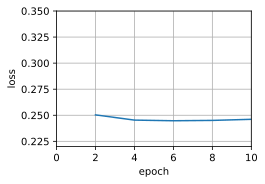

In [9]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

Quando o tamanho do lote é igual a 1, usamos SGD para otimização. Para simplificar a implementação, escolhemos uma taxa de aprendizado constante (embora pequena). No SGD, os parâmetros do modelo são atualizados sempre que um exemplo é processado. Em nosso caso, isso equivale a 1.500 atualizações por época. Como podemos ver, o declínio no valor da função objetivo diminui após uma época. Embora ambos os procedimentos tenham processado 1.500 exemplos em uma época, o SGD consome mais tempo do que a descida de gradiente em nosso experimento. Isso ocorre porque o SGD atualizou os parâmetros com mais frequência e porque é menos eficiente processar observações únicas uma de cada vez.


loss: 0.243, 0.073 sec/epoch


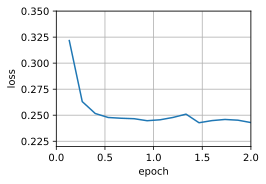

In [10]:
sgd_res = train_sgd(0.005, 1)

Finalmente, quando o tamanho do lote é igual a 100, usamos minibatch SGD para otimização. O tempo necessário por época é menor do que o tempo necessário para SGD e o tempo para a descida do gradiente do lote.


loss: 0.244, 0.003 sec/epoch


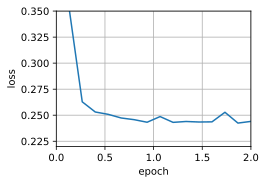

In [11]:
mini1_res = train_sgd(.4, 100)

Reduzindo o tamanho do lote para 10, o tempo de cada época aumenta porque a carga de trabalho de cada lote é menos eficiente de executar.


loss: 0.243, 0.009 sec/epoch


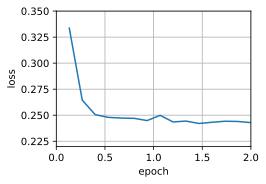

In [12]:
mini2_res = train_sgd(.05, 10)

Agora podemos comparar o tempo versus a perda dos quatro experimentos anteriores. Como pode ser visto, embora SGD convirja mais rápido do que GD em termos de número de exemplos processados, ele usa mais tempo para atingir a mesma perda do que GD porque calcular o gradiente exemplo por exemplo não é tão eficiente. O Minibatch SGD é capaz de compensar a velocidade de convergência e a eficiência de computação. Um tamanho de minibatch de 10 é mais eficiente do que SGD; um tamanho de minibatch de 100 supera até mesmo o GD em termos de tempo de execução.


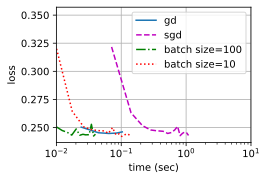

In [13]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## Implementação concisa

No Gluon, podemos usar a classe `Trainer` para chamar algoritmos de otimização. Isso é usado para implementar uma função de treinamento genérica. Usaremos isso em todo o capítulo atual.


In [14]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    # value to get L2Loss in PyTorch
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)/2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

Usar o Gluon para repetir o último experimento mostra um comportamento idêntico.


loss: 0.245, 0.011 sec/epoch


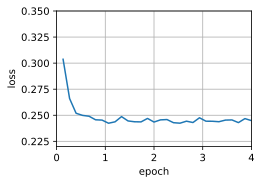

In [15]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

## Sumário

* A vetorização torna o código mais eficiente devido à sobrecarga reduzida decorrente da estrutura de aprendizado profundo e devido à melhor localização da memória e armazenamento em cache em CPUs e GPUs.
* Há uma compensação entre a eficiência estatística decorrente do SGD e a eficiência computacional decorrente do processamento de grandes lotes de dados por vez.
* A descida gradiente estocástica do Minibatch oferece o melhor dos dois mundos: eficiência computacional e estatística.
* No minibatch SGD, processamos lotes de dados obtidos por uma permutação aleatória dos dados de treinamento (ou seja, cada observação é processada apenas uma vez por época, embora em ordem aleatória).
* É aconselhável diminuir as taxas de aprendizagem durante o treinamento.
* Em geral, minibatch SGD é mais rápido do que SGD e gradiente descendente para convergência para um risco menor, quando medido em termos de tempo de clock.

## Exercícios

1. Modifique o tamanho do lote e a taxa de aprendizado e observe a taxa de declínio para o valor da função objetivo e o tempo consumido em cada época.
1. Leia a documentação do MXNet e use a função da classe `Trainer` `set_learning_rate` para reduzir a taxa de aprendizagem do minibatch SGD para 1/10 de seu valor anterior após cada época.
1. Compare o minibatch SGD com uma variante que, na verdade, *obtém amostras com substituição* do conjunto de treinamento. O que acontece?
1. Um gênio do mal replica seu conjunto de dados sem avisar você (ou seja, cada observação ocorre duas vezes e seu conjunto de dados cresce para o dobro do tamanho original, mas ninguém lhe disse). Como o comportamento do SGD, do minibatch SGD e do gradiente de descida muda?


[Discussão](https://discuss.d2l.ai/t/1068)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTMwNjcxODc0OCw1MTkzODI4NTUsMjIyOD
I4MjM5XX0=
-->
